# R-GAP: Recursive Gradient Attack on Privacy

This notebook shows an example for a **single image gradient inversion** as described in "R-GAP: Recursive Gradient Attack on Privacy
". The setting is a custom CNN from the paper for CIFAR-10 and the federated learning algorithm is **fedSGD**.

Paper URL: https://openreview.net/forum?id=RSU17UoKfJF

This is attack is probably the least modular, compared to other attacks implemented in this framework, the code will likely not work for any other model than the custom CNN. This is partly a code problem, partly a question of how R-GAP would be used with other activation functions aside from leaky ReLU. The code here is a port of the original implementation from https://github.com/JunyiZhu-AI/R-GAP

#### Abstract
Federated learning frameworks have been regarded as a promising approach to break the dilemma between demands on privacy and the promise of learning from large collections of distributed data. Many such frameworks only ask collaborators to share their local update of a common model, i.e. gradients with respect to locally stored data, instead of exposing their raw data to other collaborators. However, recent optimization-based gradient attacks show that raw data can often be accurately recovered from gradients. It has been shown that minimizing the Euclidean distance between true gradients and those calculated from estimated data is often effective in fully recovering private data. However, there is a fundamental lack of theoretical understanding of how and when gradients can lead to unique recovery of original data. Our research fills this gap by providing a closed-form recursive procedure to recover data from gradients in deep neural networks. We name it Recursive Gradient Attack on Privacy (R-GAP). Experimental results demonstrate that R-GAP  works as well as or even better than optimization-based approaches at a fraction of the computation under certain conditions. Additionally, we propose a Rank Analysis method, which can be used to estimate the risk of gradient attacks inherent in certain network architectures, regardless of whether an optimization-based or closed-form-recursive attack is used. Experimental results demonstrate the utility of the rank analysis towards improving the network's security. Source code is available for download from https://github.com/JunyiZhu-AI/R-GAP.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

/home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["attack=rgap", "case=1_single_image_small", "case.model=cnn6"])
          
device = torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_image_small with server type honest_but_curious.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.user.user_idx = 1

cfg.case.user.num_data_points = 1 # The attack is designed for only one data point


### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
torch.save(model.state_dict(), '/home/zx/Gitrepo/breaching/model_checkpoint/cnn6')
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

<class 'torch.jit._script.RecursiveScriptModule'>
Files already downloaded and verified
Model architecture cnn6 loaded with 154,266 parameters and 0 buffers.
Overall this is a data ratio of      50:1 for target shape [1, 3, 32, 32] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: cnn6
        model state: default
        

    Secrets: {}
    
Attacker (of type RecursiveAttacker) with settings:
               inversion:
                - step size: 0.01
                - steps    : 0.01
                


### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 1 in model mode: eval.


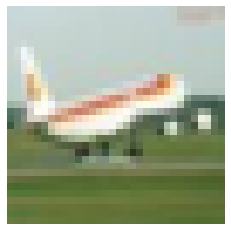

In [6]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

In [7]:
# print(len(server_payload['parameters']))
# server_payload.keys()
print(server_payload['metadata']) 
server_payload['metadata']['shape']
# print(shared_data['metadata'])
# print(len(server_payload['metadata']))
# shapes = [p.shape for p in server_payload['parameters']]
# for layer in attacker.model_template.children():
#     print(layer)
# print(shapes)

{'db': {'name': None}, 'name': 'CIFAR10', 'modality': 'vision', 'task': 'classification', 'path': '/home/zx/data/cifar10', 'size': 50000, 'classes': 10, 'shape': [3, 32, 32], 'normalize': True, 'mean': [0.4914672374725342, 0.4822617471218109, 0.4467701315879822], 'std': [0.24703224003314972, 0.24348513782024384, 0.26158785820007324], 'augmentations_train': {'RandomCrop': [32, 4], 'RandomHorizontalFlip': 0.5}, 'augmentations_val': None, 'default_clients': 10, 'partition': 'balanced', 'examples_from_split': 'validation', 'batch_size': 128, 'caching': False}


[3, 32, 32]

In [13]:
# print(len(server_payload['parameters']))
# shared_data.keys()

# shapes = [p.shape for p in server_payload['parameters']]
# for layer in attacker.model_template.children():
#     print(layer)
# print(shapes)
# params_list = list[server_payload['parameters']]
type(server_payload['parameters'])
server_payload['parameters'][-2].t().shape[0]

3200

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Linear(in_features=3200, out_features=10, bias=True)
LeakyReLU(negative_slope=0.2)
Flatten(start_dim=1, end_dim=-1)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
lstsq residual: [3.3337675e-15], rank: 3136 -> 3136, max/min singular value: 1.39e+00/2.61e-01
LeakyReLU(negative_slope=0.2)
Conv2d(36, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
lstsq residual: [2.5897465e-15], rank: 4356 -> 4356, max/min singular value: 1.26e+00/1.28e-02
LeakyReLU(negative_slope=0.2)
Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
lstsq residual: [6.63683e-13], rank: 4356 -> 4356, max/min singular value: 1.26e+00/1.50e-02
LeakyReLU(negative_slope=0.2)
Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
lstsq residual: [2.3603436e-10], rank: 4356 -> 4356, max/min singular value: 1.27e+00/5.87e-03
LeakyReLU(negative_slope=0.2)
Conv2d(12, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [12]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

/home/zx/Gitrepo/breaching/breaching/analysis/metrics.py:24: UserWarning: To utilize wavelet SSIM, install pytorch wavelets from https://github.com/fbcotter/pytorch_wavelets.
  warnings.warn(
/home/zx/Gitrepo/breaching/breaching/analysis/metrics.py:143: UserWarning: To utilize registered PSNR, install kornia.
  warnings.warn("To utilize registered PSNR, install kornia.")


Files already downloaded and verified
METRICS: | MSE: 0.0000 | PSNR: 45.11 | FMSE: 3.0056e-12 | LPIPS: 0.00|
 R-PSNR:  nan | IIP-pixel: 100.00% | SSIM: nan | max R-PSNR:  nan | max SSIM: nan | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

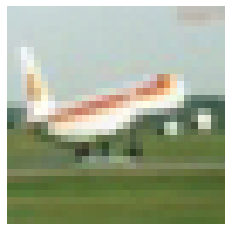

In [9]:
user.plot(reconstructed_user_data)

torch.save(reconstructed_user_data['data'], '/home/zx/Gitrepo/breaching/out/gap_rec_cifar10_idx0.pt')

### Notes:
* As analytic attack, this algorithm cannot recovery multiple data points
* The implementation of this attack ports the original unwrapping of the convolution operations into massive linear operators, this is likely not a super scalable implementation for larger-scale experiments.
* An interested insight from the R-GAP paper that is not visible in this experiment is how well the attack scales and is enabled by the rank of these operators, which naturally translates into the width of these neural networks and underpins why wide neural networks are so much more susceptible to these attacks.